<a href="https://colab.research.google.com/github/Jaykim1234/Python/blob/main/2_EU_total_analysis_std_CA_robust_ridge_df_GDP_1_EU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Sources
# https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
# https://nbviewer.jupyter.org/github/OscarEngelbrektson/SyntheticControlMethods/blob/master/examples/user_guide.ipynb

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
filename = '/content/drive/MyDrive/Colab Notebooks/thesis/data/all_data_total_EU_GDP_CA_1.csv'

In [29]:
import warnings
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from typing import List
from operator import add
from toolz import reduce, partial
from scipy import stats
from scipy.optimize import fmin_slsqp
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from matplotlib import style
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# read data file
# pandas read_csv
data = pd.read_csv(filename) 
data = data.loc[data.year >= 2006]
raw_data = copy.deepcopy(data)# Copy dataframe

In [30]:
display(data)

,country,year,CA,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,2473,...,9.912729,8.640000,11.042234
1,Brazil,2007,2451,...,9.912729,8.330000,12.918339
2,Brazil,2008,3441,...,9.912729,7.340000,14.265880
3,Brazil,2009,2917,...,9.912729,8.520000,7.168936
4,Brazil,2010,3655,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,-108255,...,1.130620,9.150000,2.100000
131,EU,2017,-99874,...,1.130620,8.158334,2.800000
132,EU,2018,-111992,...,1.130620,7.283333,2.100000
133,EU,2019,-113119,...,1.130620,6.716667,1.600000


In [31]:
# Separate Date set before and after brexit

data_before =  data.loc[data.year <= 2016]
data_after =  data.loc[data.year >= 2017]

In [32]:
# Display before Brexit data

display(data_before)

,country,year,CA,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,2473,...,9.912729,8.64000,11.042234
1,Brazil,2007,2451,...,9.912729,8.33000,12.918339
2,Brazil,2008,3441,...,9.912729,7.34000,14.265880
3,Brazil,2009,2917,...,9.912729,8.52000,7.168936
4,Brazil,2010,3655,...,8.328785,7.74000,16.647691
...,...,...,...,...,...,...,...
126,EU,2012,-81354,...,1.393386,10.93333,-0.400000
127,EU,2013,-97270,...,1.393386,11.44167,0.300000
128,EU,2014,-109969,...,1.393386,10.90000,1.800000
129,EU,2015,-111525,...,1.130620,10.06667,2.300000


In [33]:
# Display after Brexit data

display(data_after)

,country,year,CA,...,education,unemployment rate,GDP growth rate
11,Brazil,2017,2771,...,6.933517e+00,12.820000,5.041237
12,Brazil,2018,3859,...,6.933517e+00,12.330000,6.323827
13,Brazil,2019,3356,...,6.933517e+00,12.080000,5.742885
14,Brazil,2020,2832,...,5.720481e+00,11.970000,0.583997
26,Canada,2017,12175,...,2.798925e-01,6.400000,5.682746
27,Canada,2018,14465,...,2.798925e-01,5.891667,4.228967
28,Canada,2019,17085,...,2.798925e-01,5.733333,3.565128
29,Canada,2020,10443,...,2.113434e-01,9.558333,-4.615504
41,China,2017,45394,...,5.491684e+00,3.900000,11.473923
42,China,2018,46655,...,5.491684e+00,3.800000,10.485749


In [34]:
# Display before Brexit data ( EU only ) 

display(data_before.loc[data_before.country == 'core_EU'])

,country,year,CA,...,education,unemployment rate,GDP growth rate


In [35]:
# Display after Brexit data (EU only)  

display(data_after.loc[data_after.country == 'core_EU'])

,country,year,CA,...,education,unemployment rate,GDP growth rate


In [36]:
def show_mean_change(main_variable, treatment_year, input_data):

  features = [main_variable,'inflation','education','unemployment rate','GDP growth rate']

  # Divide the data with treatment year
  data_before =  input_data.loc[input_data.year <= treatment_year]
  data_after  =  input_data.loc[input_data.year >  treatment_year]

  # List of countries in a dataset
  country_lst = list(data['country'].unique())

  for country0 in country_lst:
    
    # Make temporary empty dictionary
    dic_result_before = {}
    dic_result_after = {}
    dic_t_test = {}

    for feature in features:
      mean_before = data_before.loc[data_before.country == country0][feature].mean() # Mean of features before treatment
      mean_after = data_after.loc[data_after.country == country0][feature].mean()    # Mean of features after treatment

      dic_result_before[feature+'_before'] = mean_before # Enter values into dictionary
      dic_result_after[feature+'_after'] = mean_after
    
      # Make data that is only about one country
      data_country_before = data_before.loc[data_before.country == country0] # Before treatment
      data_country_after  = data_after.loc[data_after.country == country0]   # After treatment

      dic_t_test[feature] = stats.ttest_ind(data_country_before[feature], data_country_after[feature], equal_var=False)  # Do t-test 

    print('*'*600)
    print('< '+country0 +' >')
    print('')
    print(dic_result_before)
    print(dic_result_after)
    print('')
    print('t-test result')
    print(dic_t_test)
  
  print('')
  print('#'*600)
  print('t-test for all country means')
  print('')
  print(stats.ttest_ind(data_before[feature], data_after[feature], equal_var=False))

In [37]:
# Standardize independent variables
# mean 0 / variance 1

data[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data[['inflation','education','unemployment rate','GDP growth rate']])
data

,country,year,CA,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,2473,...,0.381658,1.126198,1.024069
1,Brazil,2007,2451,...,0.381658,0.987292,1.345315
2,Brazil,2008,3441,...,0.381658,0.543690,1.576054
3,Brazil,2009,2917,...,0.381658,1.072428,0.360845
4,Brazil,2010,3655,...,0.223318,0.722923,1.983891
...,...,...,...,...,...,...,...
130,EU,2016,-108255,...,-0.496248,1.354720,-0.507109
131,EU,2017,-99874,...,-0.496248,0.910371,-0.387248
132,EU,2018,-111992,...,-0.496248,0.518298,-0.507109
133,EU,2019,-113119,...,-0.496248,0.264384,-0.592724


In [38]:
def visulaize_origianl(data0, country,interested_variable):
  """
  Make graph with interested variable and country
  This function is to visulize the raw data 
  """

  # Make data0set that is only about entered country 
  str_expr = f"country == '{country}' " 
  data0_new = data0.query(str_expr) 

  plt.figure(figsize=(10,5)) 
  plt.plot(data0['year'],data0[interested_variable],marker="o",alpha=.6, label = f'{interested_variable} with Non {country}',color='dimgray')
  plt.plot(data0_new['year'],data0_new[interested_variable],'R',label = f'{interested_variable} with {country}',color='black')   
  plt.vlines(x=2016,   ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.gray()
  plt.legend();  
  plt.show()


In [39]:
# Country : The country you want to see
# pool: list of country in data set
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_weight_visualize(country, main_variable, data0):
  """
  This function is for showing the weight of countries from ridge ASMC
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge_rounded = weights_ridge.round(3)

  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  dic = {}
  for index in range(len(pool)-1):
    dic[pool[index]] = weights_ridge_rounded[index]
  return dic



In [40]:
# Get X and y

def X_y(country, main_variable, data0):

  features = [ 'inflation',"education",'unemployment rate','GDP growth rate']

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values

  return X,y

In [41]:

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights


def sythetic_weight(country, interested_variable, data0):   
  """
  Get the weight of synthetic control.
  """
  data_weights = get_w(X_y(country, interested_variable, data0)[0], X_y(country, interested_variable, data0)[1])
  print("Sum:", data_weights.sum())

  return np.round(data_weights, 4)

def synthetic_plot(country,main_variable, data0):
  """
  Show the plot of synthetic control
  """
  features = [main_variable]
  data_synth_1 = data.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, 'CA', data0))
  
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  plt.vlines(x=2016, ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable} ")
  plt.legend();




In [42]:


def agumented_synthetic_control(country, main_variable, data0):
  """
  This function is to make dataframe that contain the value of ASCM

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  data0_country['ASCM'] = data_synth_lr

  return data0_country

def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def agumented_synthetic_control_dataframe(country, main_variable, data0):

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = agumented_synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2['Difference'] = data2[main_variable]- data2['ASCM']

  # Make dataframe that contain pre-treatment period only
  data3 = data2.loc[data2.year <= 2016]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data3[main_variable], data3['ASCM'])
  print('RMSPE :', rmspe )

  return data2[['country','year',main_variable,'ASCM','Difference']]


In [43]:
# Country : The country you want to see
# pool: list of country in data set
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_synthetic_control_visualize(country, main_variable, data0):

  
  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  
  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label="Augmented Synthetic Control",color='black')
  plt.vlines(x=2016,  ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable}")
  plt.legend();


In [44]:
def placebo_visualize(input_data, interested_country, interested_variable):
  # Make dataframe that contains

  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  synth_list = []
  for country in pool:
    # Make temporary dataframe that contains synthetic values
    temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
    synth_list.append(temp_dataframe)
  
  # Make gahtered data
  data_synth_all= pd.concat(synth_list, axis = 0, sort= False)

  # Make a plot for all country except interested_country
  plt.figure(figsize=(10,6))
  plt.plot(data_synth_all['year'],data_synth_all[f'{interested_variable}']-data_synth_all['ASCM'],marker="o",alpha=.6, label = 'placebo effect',color='dimgray') 
  
  # Make a plot for interested country
  temp_dataframe2 = agumented_synthetic_control(interested_country, interested_variable, input_data)

  plt.plot(temp_dataframe2['year'],temp_dataframe2[f'{interested_variable}']-temp_dataframe2['ASCM'],'R',alpha=.6, label = f'Brexit impact on {interested_country}',color='black')
  plt.vlines(x=2016, ymin=-100000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel("")
  plt.legend();  
  plt.show()

In [45]:
# Note
# Treatment effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the interested country)
# Placebo effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the all the other country except the main country)

# P-value is calculated with following two steps 
# - 1st step : Count the number of placebo effects that have larger absolute values than those of treatment effects.
# - 2nd step : Divide the value from 1st step by the total number of countries 

def Robust_analysis(input_data, interested_country, interested_variable):
  # Make dataframe that contains

  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  synth_list = []
  for country in pool:
    # Make temporary dataframe that contains synthetic values
    temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
    # print(temp_dataframe)
    value_agumented_synthetic_control    = temp_dataframe.iloc[-1,-1]
    value_interested_variable  = temp_dataframe.iloc[-1,2]

    # print(value_interested_variable, value_synthetic_control)
    placebo_effect = value_interested_variable - value_agumented_synthetic_control
    synth_list.append(placebo_effect)
  
  # Calculate synthetic value for interested country in 2020 year
  synth_interested_country = agumented_synthetic_control(interested_country, interested_variable, input_data)

  value_agumented_synthetic_control_main_country = synth_interested_country.iloc[-1,-1]
  value_interested_variable_main_country = synth_interested_country.iloc[-1,2]

  treatment_effect = value_interested_variable_main_country - value_agumented_synthetic_control_main_country

  # Make dictionray to summarise placebo effect
  
  placebo_effect_dictionary = {}
  for now_country, placebo_value in zip(pool[0:-1],synth_list[0:-1]):
    placebo_effect_dictionary[now_country] = placebo_value
  print('Placebo effects:',placebo_effect_dictionary )


  # Make a new list that contains placebo effects which are larger than the treatment effect
  sorted_list= [placebo_effect for placebo_effect in synth_list if abs(placebo_effect) > abs(treatment_effect)]

  p_value = len(sorted_list)/(len(synth_list)-1) # -1: exclude the interested country in the list

  # Print treament effect
  print(f'Brexit Treatment Effect for the Year 2020 ({interested_country}): {treatment_effect}')
  print(f'p-value : {p_value}')

In [46]:
# Note
# Treatment effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the interested country)
# Placebo effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the all the other country except the main country)

# P-value is calculated with following two steps 
# - 1st step : Count the number of placebo effects that have larger absolute values than those of treatment effects.
# - 2nd step : Divide the value from 1st step by the total number of countries 

def Robust_analysis_2(input_data, interested_country, interested_variable):
  # Make list that contains sum of absolute placebo effect value
  placebo_all_year = []

  # Make list that contains sum of absolute treatment effect value
  treatment_all_year = []

  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  # Make list of year in a dataframe
  pool_year = list(input_data['year'].unique())
  current_year = 2016
  

  for year in range(-4,0):# year is -4,-3,-2,-1 . This is to select ASCM from 2016 to 2020
    synth_list = []
    current_year += 1

    for country in pool:
      # Make temporary dataframe that contains synthetic values
      temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
      # print(temp_dataframe)
      value_agumented_synthetic_control    = temp_dataframe.iloc[year,-1] # (left: row), (right:column)
      value_interested_variable  = temp_dataframe.iloc[year,2]

      # print(value_interested_variable, value_synthetic_control)
      placebo_effect = value_interested_variable - value_agumented_synthetic_control
      synth_list.append(placebo_effect)


    # Calculate synthetic value for interested country in 2020 year
    synth_interested_country = agumented_synthetic_control(interested_country, interested_variable, input_data)

    value_agumented_synthetic_control_main_country = synth_interested_country.iloc[year,-1]
    value_interested_variable_main_country = synth_interested_country.iloc[year,2]

    treatment_effect = value_interested_variable_main_country - value_agumented_synthetic_control_main_country


    treatment_all_year.append(abs(treatment_effect))
    # Make dictionray to summarise placebo effect
    
    placebo_effect_dictionary = {}
    for now_country, placebo_value in zip(pool[0:-1],synth_list[0:-1]):
      placebo_effect_dictionary[now_country] = placebo_value
    print('Placebo effects:',placebo_effect_dictionary )


    # Make a new list that contains placebo effects which are larger than the treatment effect
    sorted_list= [placebo_effect for placebo_effect in synth_list if abs(placebo_effect) > abs(treatment_effect)]

    p_value = len(sorted_list)/(len(synth_list)-1) # -1: exclude the interested country in the list

    # Print treament effect
    print(f'Brexit Treatment Effect for the Year {current_year} ({interested_country}): {treatment_effect}')
    print(f'p-value : {p_value}')
    print('')
    print('')

In [47]:
show_mean_change('CA', 2016, raw_data)

************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
< Brazil >

{'CA_before': 2989.818181818182, 'inflation_before': 5.963636363636363, 'education_before': 8.651079890909092, 'unemployment rate_before': 8.031818181818181, 'GDP growth rate_before': 10.19805513381818}
{'CA_after': 3204.5, 'inflation_after': 3.5, 'education_after': 6.630257975, 'unemployment rate_after': 12.299999999999999, 'GDP growth rate_after': 4.422986319}

t-test result
{'CA': 

In [48]:
agumented_weight_visualize('EU', 'CA', data)

{'Brazil': 25.675,
 'Canada': 12.676,
 'China': -1.841,
 'India': -10.045,
 'Japan': 6.079,
 'Russia': -7.343,
 'Switzerland': -1.161,
 'USA': -1.646}

In [49]:
sythetic_weight('EU', 'CA', data)

Sum: 1.0000000000000007


array([0.    , 0.9873, 0.    , 0.    , 0.    , 0.    , 0.    , 0.0127])

In [50]:
agumented_synthetic_control_dataframe('EU', 'CA', data)


RMSPE : 0.0914321345713792


,country,year,CA,ASCM,Difference
120,EU,2006,-41134,-35015.539107,-6118.460893
121,EU,2007,-57047,-56858.649102,-188.350898
122,EU,2008,-37986,-41903.152109,3917.152109
123,EU,2009,-48781,-52989.508633,4208.508633
124,EU,2010,-58028,-50700.022361,-7327.977639
125,EU,2011,-52600,-61782.457199,9182.457199
126,EU,2012,-81354,-75954.920908,-5399.079092
127,EU,2013,-97270,-99664.934553,2394.934553
128,EU,2014,-109969,-109641.252569,-327.747431
129,EU,2015,-111525,-109653.322074,-1871.677926


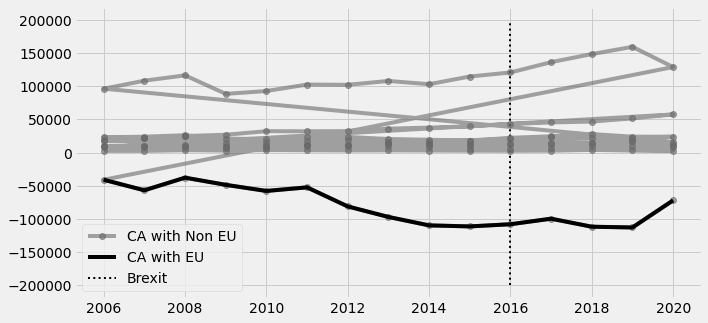

In [51]:
visulaize_origianl(data,'EU', 'CA')

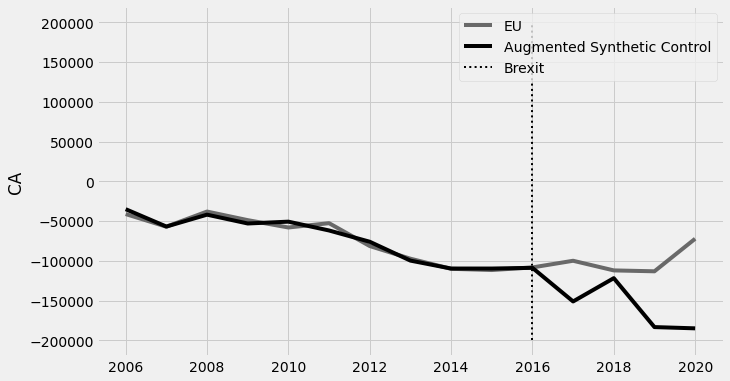

In [52]:
agumented_synthetic_control_visualize('EU', 'CA', data)

Sum: 1.0000000000000007


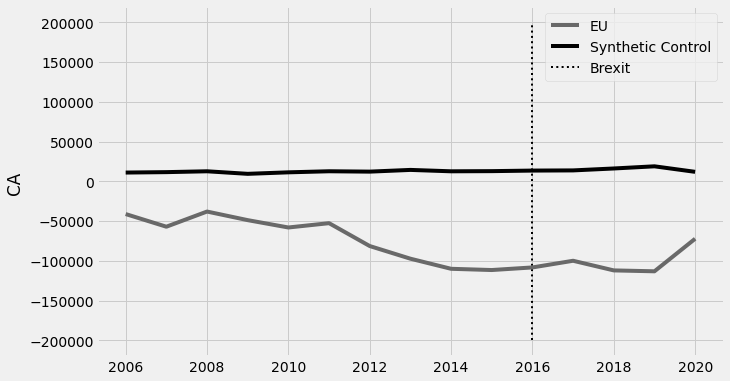

In [53]:
synthetic_plot('EU', 'CA', data)

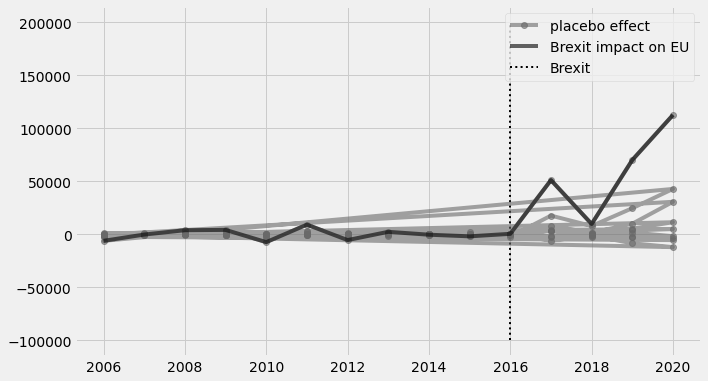

In [54]:
placebo_visualize(data, 'EU', 'CA')

In [55]:
 Robust_analysis(data, 'EU', 'CA')

Placebo effects: {'Brazil': -3266.920146120304, 'Canada': -5425.6333420144965, 'China': 30709.115540972365, 'India': 5017.217077925636, 'Japan': -12047.104407606406, 'Russia': 11447.171329684885, 'Switzerland': -1706.0319295132067, 'USA': 42846.13704304675}
Brexit Treatment Effect for the Year 2020 (EU): 112644.15260845539
p-value : 0.0


In [56]:
Robust_analysis_2(data, 'EU', 'CA')

Placebo effects: {'Brazil': -1689.215583079752, 'Canada': -2437.349713379688, 'China': 7919.0367633969145, 'India': 3581.2196747635244, 'Japan': -5964.623360309299, 'Russia': 4045.3744954843096, 'Switzerland': 3113.3938158344135, 'USA': 17670.951170661836}
Brexit Treatment Effect for the Year 2017 (EU): 51155.92070037496
p-value : 0.0


Placebo effects: {'Brazil': -210.59642675871828, 'Canada': -763.9357663538176, 'China': 1497.556349884726, 'India': 445.1019818066561, 'Japan': -1133.2246036458564, 'Russia': 1127.893332484071, 'Switzerland': -2346.1685888354987, 'USA': 7898.752294215461}
Brexit Treatment Effect for the Year 2018 (EU): 9763.425192933559
p-value : 0.0


Placebo effects: {'Brazil': -2079.365402977425, 'Canada': -2630.836852505254, 'China': 10048.38931518227, 'India': 4027.163746849128, 'Japan': -8442.243808188006, 'Russia': 5419.107710082611, 'Switzerland': 1676.1211306728, 'USA': 24678.357288450992}
Brexit Treatment Effect for the Year 2019 (EU): 70149.35582781894
p-valu